In [1]:
# Import csvs
import pandas as pd
import math
import numpy as np

# Brush: 3DEDB3 (Bob Ara), Calibrations applied

# Brushing exterior incisive
inc_ext = pd.read_csv('magnetometer_C04BC93BEDB3_1503407020.210412_0_0.csv',  sep=' ', header = None) 

# Brushing interior incisive
inc_int = pd.read_csv('magnetometer_C04BC93BEDB3_1503407076.781844_0_0.csv', sep=' ', header = None)

# Brushing exterior - interior (transition at 10 sec)
incs = pd.read_csv('magnetometer_C04BC93BEDB3_1503407125.412623_0_0.csv', sep=' ', header = None)

# Upper left molar exterior -> upper right molar interior (transition at 10 sec)
lext_rint = pd.read_csv('magnetometer_C04BC93BEDB3_1503407341.231807_0_0.csv', sep=' ', header = None)

# Upper left molar exterior -> upper right molar interior -> upper right molar exterior (transitions at 10 sec intervals)
lext_rint_rext = pd.read_csv('magnetometer_C04BC93BEDB3_1503407410.508904_0_0.csv', sep=' ', header = None)

files = list([inc_ext, inc_int, incs, lext_rint, lext_rint_rext])

In [2]:
# Definition 2D plot

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
  
def plot_kf_angles(df):
    
    dt = 0.02
    ts = df['ts']*dt

    fig, ax = plt.subplots()
    ax.plot(ts, df['kalman_roll'], color='g', label='kalman_roll')
    ax.plot(ts, df['kalman_pitch'], color='r', label='kalman_pitch')
    ax.plot(ts, df['yaw'], color='b', label='yaw')
    ax.plot(ts, df['acc_angle_z'], color='y', label='tilt_angle')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax.set_xlabel('Time (secs)')
    ax.set_ylabel('$^\circ$ degrees')
    plt.title('Kalman Rotations')
    plt.show(fig)
    
def plot_2d_brushing(df):
    
    dt = 0.02
    ts = df['ts']*dt

    fig2d, ax2 = plt.subplots()
    ax2.scatter(df['kalman_roll'], -df['kalman_pitch'], c=ts, cmap='Vega20') # x-start: 0, y-start: -90
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    m = cm.ScalarMappable(cmap='Vega20')
    m.set_array(ts)
    cbar = plt.colorbar(m)
    plt.title('2D view movement - XYZ Orientation')
    plt.show(ax2)   

#### Run calculations and visualize plots

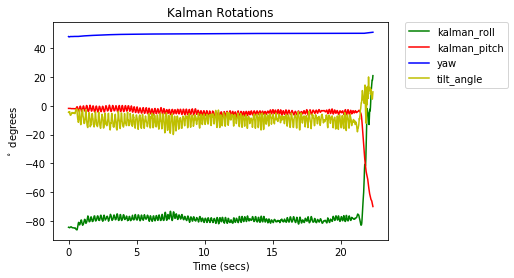

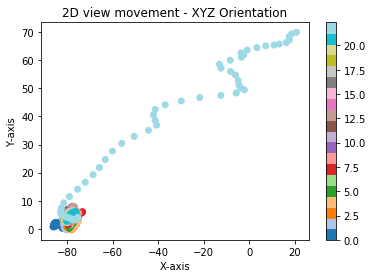

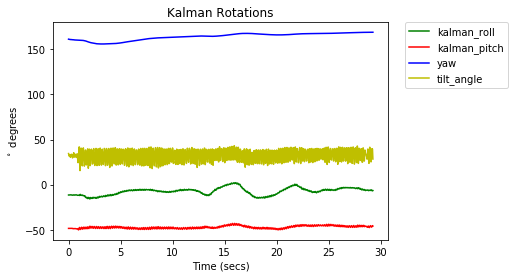

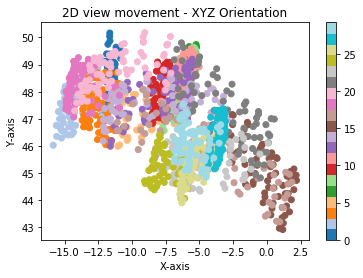

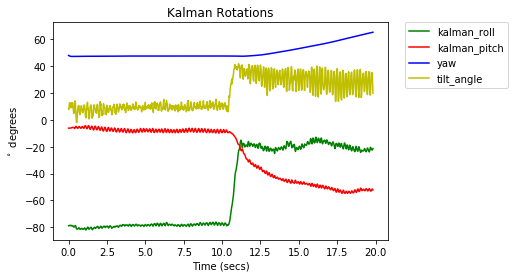

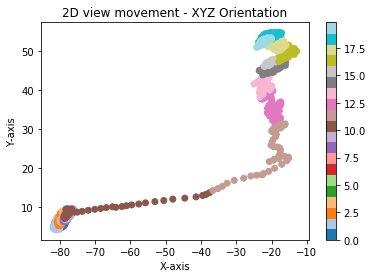

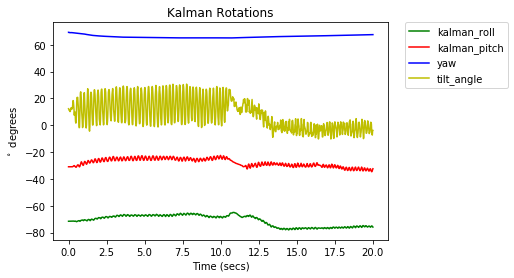

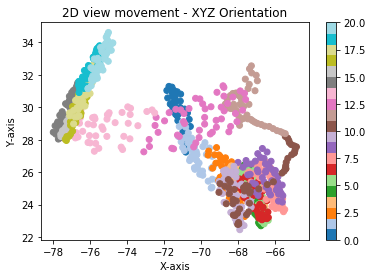

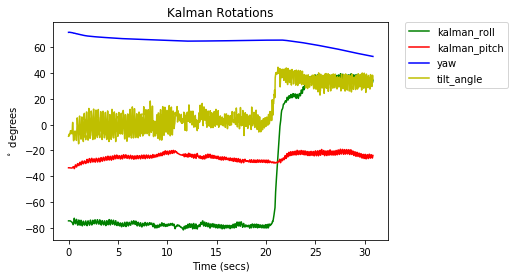

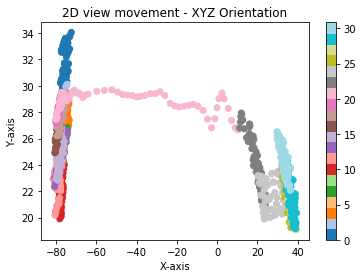

In [3]:
import matplotlib.pyplot as plt
from prop_defs import angles_comp, transform_units, kalman_filter, mag_yaw

for file in files:
    
    df = pd.DataFrame(file)
    df.columns = ['mag_x', 'mag_y', 'mag_z', 'temp', 'acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z', 'vib_ind', 'ts']

    # Apply calibrations and sensitivity
    pdf = transform_units(df, 1,1,1) # acc, gyr, mag calibrated

    # Compute euler angles
    cdf = angles_comp(pdf, 50) # 50 Hz
    cdf['ts'] = cdf.index

    # Kalman filter
    kdf = kalman_filter(cdf, 1, 50) # vibration on, 50 Hz

    # Tilt-compensated yaw computation with magnetometer
    vals_df = mag_yaw(kdf, pdf) # kalman results, data with magnetometer values
    vals_df['ts'] = vals_df.index # time index

    # View dataframe
    vals_df = pd.merge(vals_df, cdf[['acc_angle_z', 'ts']], how = 'inner', on = 'ts') # Optional step, add tilt angle

    # Plot rotational angles
    
    plot_kf_angles(vals_df)
    
    # Plot 2D
    
    plot_2d_brushing(vals_df)